# Final model verification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsRegressor
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models, Sequential, Input, Model
from tensorflow.data.experimental import cardinality
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.python.ops import image_ops
from tensorflow.python.ops import io_ops
import joblib

## Data and model path

In [2]:
path_CNN_models = r'C:\Users\pitip\code\ClaireLeroux44\ArtRecognition\models\Full_training'
model_name = '20201214_150118_VGG16_v4_31'

path_KNN_models = r'C:\Users\pitip\code\ClaireLeroux44\ArtRecognition\models\KNN_models\CNN_comparison'
KNN_model = 'KNN_model_20201214_150118_VGG16_v4_31_Top_12.joblib'

In [3]:
test_dataset_path = r'C:\Users\pitip\OneDrive\Bureau\raw_data\Donnees_tests\Data_test'
#test_dataset_path = r'C:\Users\pitip\OneDrive\Bureau\raw_data\Clean_Data\Recog_test_dataset\_all'

In [4]:
all_data_info = pd.read_csv('../ArtRecognition/data/all_data_info.csv')
artist_number = pd.read_csv('../ArtRecognition/data/artists_numbers.csv')

## Function definition

In [5]:
IMG_SIZE = (224, 224)

In [6]:
def path_to_image(path, image_size, num_channels, interpolation):
    img = io_ops.read_file(path)
    img = image_ops.decode_image(img, channels=num_channels, expand_animations=False)
    img = image_ops.resize_images_v2(img, image_size, method=interpolation)
    img.set_shape((image_size[0], image_size[1], num_channels))
    return img

In [7]:
def Embedding_generation(root_path, embedding_model):
    img_list = []
    label_list = []
    for root, dirs, files in os.walk(root_path, topdown=False):
        for name in files:
            img_list.append(os.path.join(root, name))
            label_list.append(name)

    #img_list = img_list[:5]
    #label_list = label_list[:5]
    DF_list = []
    for im_path, label in zip(img_list, label_list):
        im_iops = path_to_image(im_path, IMG_SIZE, 3, 'bilinear')
        im_iops = np.expand_dims(im_iops,axis =0)

        image_embedding = embedding_model.predict(im_iops)
        DF_list.append(pd.DataFrame(image_embedding, index=[label]))
    Embeddings_df = pd.concat(DF_list)
    return Embeddings_df, img_list, label_list

In [8]:
def KNN_prediction(knr_model, test_path, embedding_model):
    image_embeddings_test, img_list_test, label_list_test = Embedding_generation(test_path, embedding_model)
    print(f"Test_dataset embedding computed, shape: {image_embeddings_test.shape}")

    dist, pred_label = knr_model.kneighbors(X=image_embeddings_test, n_neighbors=3, return_distance=True)
    pred_1 = []
    dist_1 = []
    pred_2 = []
    dist_2 = []
    pred_3 = []
    dist_3 = []
    for i in range(len(img_list_test)):
        pred_1.append(label_list.iloc[pred_label[i][0]][0])
        pred_2.append(label_list.iloc[pred_label[i][1]][0])
        pred_3.append(label_list.iloc[pred_label[i][2]][0])
        dist_1.append(dist[i][0])
        dist_2.append(dist[i][1])
        dist_3.append(dist[i][2])

    print('Neighbors identified')
    if test_path == r'C:\Users\pitip\OneDrive\Bureau\raw_data\Clean_Data\Recog_test_dataset\_all':
        results_df = pd.DataFrame({'Label': label_list_test, 'Original_image': [os.path.splitext(s)[0].split('_')[0]+'.jpg' for s in label_list_test],
                           'Transform':[int(os.path.splitext(s)[0].split('_')[-1]) if len(os.path.splitext(s)[0].split('_'))==2 else 0 for s in label_list_test], 
                           'pred_1':pred_1,'pred_2':pred_2, 'pred_3':pred_3, 'dist_1':dist_1, 'dist_2':dist_2, 'dist_3':dist_3})
    else:
        results_df = pd.DataFrame({'Label': label_list_test, 'pred_1':pred_1,'pred_2':pred_2, 'pred_3':pred_3, 'dist_1':dist_1, 'dist_2':dist_2, 'dist_3':dist_3})
    
    return results_df, img_list_test, label_list_test

In [9]:
def top3_accuracy(results_df):
    results_df2 = results_df[['Label', 'Original_image', 'Transform', 'pred_1', 'pred_2', 'pred_3']].copy()
    results_df2['1_st'] = (results_df2['pred_1']==results_df2['Original_image'])*1
    results_df2['2_nd'] = (results_df2['pred_2']==results_df2['Original_image'])*1
    results_df2['3_rd'] = (results_df2['pred_3']==results_df2['Original_image'])*1
    
    results_df2['in_top_3'] = results_df2[['1_st', '2_nd', '3_rd']].max(axis = 1)
    
    print(f"Top 3 accuracy: {results_df2['in_top_3'].sum()/len(results_df2['in_top_3']):.4f}")
    return results_df2
    

## Test data prediction and plot

In [10]:
model = load_model(os.path.join(path_CNN_models, model_name))
print(f"Model {model_name} loaded")

layer_outputs = [model.layers[-1].input]
embedding_model = models.Model(inputs=model.input, outputs=layer_outputs)

Model 20201214_150118_VGG16_v4_31 loaded


In [11]:
knr = joblib.load(os.path.join(path_KNN_models, f"KNN_model_{model_name}.joblib"))
label_list = pd.read_csv(os.path.join(path_KNN_models, f"label_list_{model_name}.csv"))

c:\users\pitip\.venvs\lewagon\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator KNeighborsRegressor from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [12]:
results_df, img_list_test, label_list_test = KNN_prediction(knr, test_dataset_path, embedding_model)

Test_dataset embedding computed, shape: (26, 400)
Neighbors identified


In [13]:
results_df.head()

,Label,pred_1,pred_2,pred_3,dist_1,dist_2,dist_3
0,5f0094b2b66e0_chagall_3-4913938.jpg,31559.jpg,40211.jpg,99482.jpg,5.133542,5.170264,5.310534
1,art_chagall_ba_gb_3d_49247_1510121103_id_10048...,91211.jpg,98471.jpg,88861.jpg,5.401965,5.478605,5.496498
2,couverte_chagall_orient_esprit-1-page-001_0.jpg,70723.jpg,5506.jpg,18548.jpg,4.965241,5.164715,5.196590
3,ob_85d129_l1180312cc.JPG,92925.jpg,101291.jpg,71978.jpg,6.060653,6.161494,6.220571
4,xpo_chagall-de-la-palette-au-metier_marc-chaga...,73992.jpg,43686.jpg,15556.jpg,4.469892,4.469892,4.470014


In [14]:
if test_dataset_path == r'C:\Users\pitip\OneDrive\Bureau\raw_data\Clean_Data\Recog_test_dataset\_all':
    accuracy_score(results_df['Original_image'], results_df['pred_1'])

In [15]:
if test_dataset_path == r'C:\Users\pitip\OneDrive\Bureau\raw_data\Clean_Data\Recog_test_dataset\_all':
    transform_list = ['original', 'crop', 'extend', 'rotate', 'contrast', 'color balance', 'noise', 'all modif']
    acc_list = []
    acc = accuracy_score(results_df['Original_image'], results_df['pred_1'])
    print(f"Overall top 1 accuracy: {acc:.4f}")
    results_df_top_3 = top3_accuracy(results_df)
    for i, transform in enumerate(transform_list):
        transform_results_df = results_df.loc[results_df['Transform']==i]
        acc = accuracy_score(transform_results_df['Original_image'], transform_results_df['pred_1'])
        acc_list.append(acc)
        top_3_transform_results_df = results_df_top_3.loc[results_df_top_3['Transform']==i]
        top3_acc = top_3_transform_results_df['in_top_3'].sum()/len(top_3_transform_results_df['in_top_3'])
        print(f"Transformation method: {transform} - Accuracy: {acc:.4f} - Top 3 accuracy: {top3_acc:.4f}")

## Prediction visualisation

In [16]:
DB_data_dir = r'C:\Users\pitip\OneDrive\Bureau\raw_data\Clean_Data'

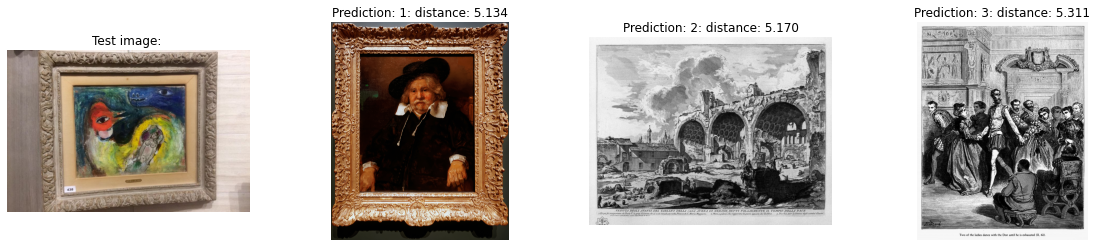

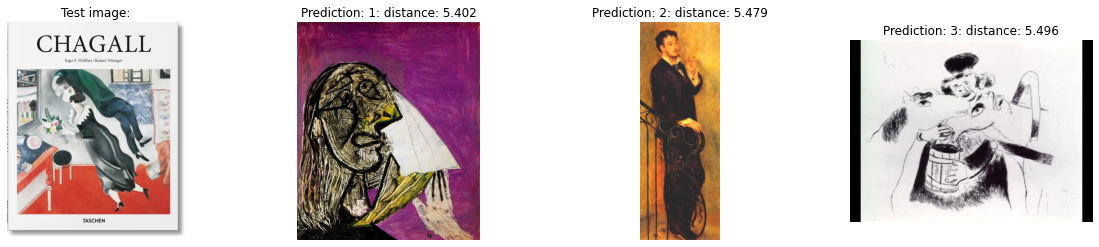

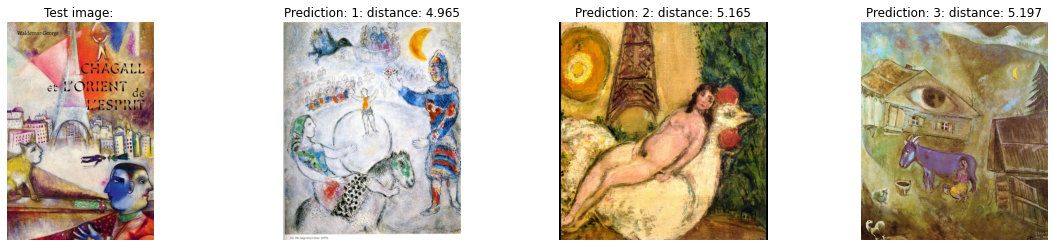

In [18]:
for j in range(3): #len(results_df)):
    fig, ax = plt.subplots(1, 4, figsize=(20,4))
    
    path_img_orig = os.path.join(test_dataset_path, img_list_test[j])
    img = plt.imread(path_img_orig)
    ax[0].imshow(img)
    ax[0].axis('off')
    ax[0].set_title('Test image: ')
    
    for i in range(3):
        id_im = results_df[f"pred_{i+1}"].iloc[j]
        art_name = all_data_info.loc[all_data_info['new_filename']==id_im, 'artist'].values[0]
        art_id = artist_number.loc[artist_number['artist']==art_name, 'artist_number'].values[0]
        art_id_train = all_data_info.loc[all_data_info['new_filename']==id_im, 'in_train'].values[0]
        if art_id_train=='True':
            train_test_dir = 'Train'
        else:
            train_test_dir = 'Test'
        path_img = os.path.join(DB_data_dir, train_test_dir, art_id, id_im)
        img = plt.imread(path_img)
        ax[i+1].imshow(img)
        ax[i+1].axis('off')
        ax[i+1].set_title(f'Prediction: {i+1}: distance: {results_df[f"dist_{i+1}"].iloc[j]:.3f}')